In [1]:
import pandas as pd
from finta import TA
import numpy as np
from pathlib import Path

In [2]:
#yahoo finance stock data (for longer timeframe)
import yfinance as yf

def stock_df(ticker, start, end):
    stock = yf.Ticker(ticker)
    stock_df = stock.history(start = start, end = end)
    return stock_df

start = pd.to_datetime('2015-01-01')
end = pd.to_datetime('today')
                     
spy_df = stock_df('SPY', start, end)

In [3]:
spy_df["Actual Returns"] = spy_df["Close"].pct_change()
spy_df.dropna(inplace=True)

In [4]:
spy_df["RSI"] = TA.RSI(spy_df, 14)
spy_df["CCI"] = TA.CCI(spy_df, 14)
spy_df["ROC"] = TA.ROC(spy_df, 20)
spy_df["STO"] = TA.STOCH(spy_df)
spy_df.dropna(inplace=True)


In [5]:
X = spy_df[['RSI', 'CCI', 'ROC', 'STO']].shift().dropna().copy()

spy_df['Signal'] = 0.0

spy_df.loc[(spy_df['Actual Returns'] >= 0), 'Signal'] = 1
# Generate signal to hold in case profits does not exceed transaction costs (less than 1% gain)
spy_df.loc[(spy_df['Actual Returns'] < 0.01), 'Signal'] = 0
# Generate signal to sell stock short
spy_df.loc[(spy_df['Actual Returns'] < 0), 'Signal'] = -1



y = spy_df['Signal']

In [6]:
# Import the neccessary Date function
from pandas.tseries.offsets import DateOffset

# Use the following code to select the start of the training period: `training_begin = X.index.min()`
training_begin = X.index.min()
print(training_begin)

# Use the following code to select the ending period for the training data: `training_end = X.index.min() + DateOffset(months=3)`
training_end = X.index.min() + DateOffset(months=3)
print(training_end)

# Generate the X_train and y_train DataFrames using loc to select the rows from `training_begin` up to `training_end`
# Hint: Use `loc[training_begin:training_end]` for X_train and y_train
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Generate the X_test and y_test DataFrames using loc to select from `training_end` to the last row in the DataFrame.
# Hint: Use `loc[training_end:]` for X_test and y_test
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Use StandardScaler to scale the X_train and X_test data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

from imblearn.over_sampling import RandomOverSampler
# Use RandomOverSampler to resample the datase using random_state=1
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

2015-02-04 00:00:00
2015-05-04 00:00:00


In [7]:
# Create the classifier model.
from sklearn.svm import SVC
model = SVC()
 
# Fit the model to the data using X_train_scaled and y_train
model = model.fit(X_resampled, y_resampled)

# Use the trained model to predict the trading signals for the training data.
training_signal_predictions = model.predict(X_resampled)

# Evaluate the model using a classification report
from sklearn.metrics import classification_report
training_report = classification_report(y_resampled, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.62      0.43      0.51        30
         0.0       0.57      0.53      0.55        30
         1.0       0.59      0.80      0.68        30

    accuracy                           0.59        90
   macro avg       0.59      0.59      0.58        90
weighted avg       0.59      0.59      0.58        90



In [8]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = model.predict(X_test_scaled)

In [9]:
# Evaluate the model's ability to predict the trading signal for the testing data using a classification report
training_report = classification_report(y_test, testing_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.45      0.44      0.44       746
         0.0       0.42      0.32      0.36       732
         1.0       0.21      0.43      0.29       210

    accuracy                           0.38      1688
   macro avg       0.36      0.39      0.36      1688
weighted avg       0.41      0.38      0.39      1688



In [10]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df['predicted_returns'] = testing_signal_predictions
predictions_df['predicted_returns'].value_counts()

-1.0    723
 0.0    544
 1.0    421
Name: predicted_returns, dtype: int64

In [11]:
# Add in actual returns and calculate trading returns
predictions_df['actual_returns'] = spy_df['Actual Returns']
predictions_df['trading_algorithm_returns'] = (predictions_df['actual_returns'] * predictions_df['predicted_returns'])*-1
predictions_df

,predicted_returns,actual_returns,trading_algorithm_returns
Date,,,
2015-05-04,0.0,0.002847,-0.000000
2015-05-05,0.0,-0.011452,0.000000
2015-05-06,1.0,-0.004117,0.004117
2015-05-07,1.0,0.003990,-0.003990
2015-05-08,1.0,0.013166,-0.013166
...,...,...,...
2022-01-06,1.0,-0.000939,0.000939
2022-01-07,1.0,-0.003954,0.003954
2022-01-10,1.0,-0.001244,0.001244


<AxesSubplot:xlabel='Date'>

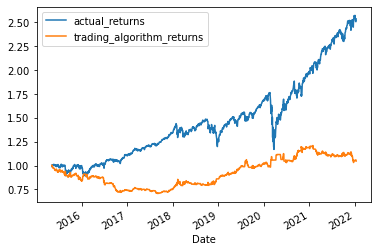

In [12]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[['actual_returns', 'trading_algorithm_returns']]).cumprod().plot()